In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
from urllib.parse import quote
import datetime
import seaborn as sns
from datetime import datetime, timedelta
import datetime
import matplotlib.pyplot as plt
# import itertools
# import statsmodels.api as sm
# from pylab import rcParams

import warnings; 
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore",category=UserWarning)
warnings.simplefilter(action="ignore",category=FutureWarning)
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['grid.linestyle'] = ':'   
plt.rcParams['axes.grid'] = True

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.color_palette("RdBu", n_colors=10)

np.float_ = np.float64

# %matplotlib inline
# %config InlineBackend.figure_formats = {'png', 'retina'}


# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen


print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('Seaborn version', sns.__version__)

Importing plotly failed. Interactive plots will not work.


Numpy version 1.26.4
Pandas version 2.2.2
Seaborn version 0.13.2


In [2]:
def get_forecast_accuracy(y, y_hat):
    # ME
    me = (y - y_hat).sum()/len(y)

    # RMSE
    rmse = math.sqrt(mean_squared_error(y, y_hat))

    # MAPE
    mape = mean_absolute_percentage_error(y, y_hat) * 100
    
    # WAPE
    wape = (y - y_hat).__abs__().sum() / y.__abs__().sum() * 100

    print("ME: %.2f, RMSE: %.2f, MAPE: %.2f%%, WAPE: %.2f%%" % (me,rmse,mape,wape))

In [3]:
cur_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("current times:", cur_time)

current times: 2024-08-06 06:14:56


In [4]:
case = pd.read_csv("./r506_pipeline/data/df2.csv", encoding="cp874" )
temp = pd.read_csv("./temp_pipeline/data/dataset/temp.csv", encoding="cp874")
rain = pd.read_csv("./rain_pipeline/data/dataset/rain.csv", encoding="cp874")
press = pd.read_csv("./pressure_pipeline/data/dataset/press.csv", encoding="cp874")
humidity = pd.read_csv("./humidity_pipeline/data/dataset/humidity.csv", encoding="cp874")

In [5]:
case.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        232 non-null    object
 1   total_case  232 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


In [6]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    312 non-null    object 
 1   temp    312 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [7]:
df = case.merge(temp,on='date',how='left')
df = df.merge(press,on='date',how='left')
df = df.merge(humidity,on='date',how='left')
df = df.merge(rain,on='date',how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        232 non-null    object 
 1   total_case  232 non-null    int64  
 2   temp        232 non-null    float64
 3   press       224 non-null    float64
 4   humidity    232 non-null    float64
 5   rain        232 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 11.0+ KB


In [8]:
# Create pandas time series with date labels correctly shown. 
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace=True)
#df['rolling_weekly_avg'] = df.new_cases.rolling(window=7).mean().fillna(0)

# create timeseries readable by fbprophet
ts = pd.DataFrame({'ds':df.index,'y':df.total_case})

# Need to have bounds if using logistc growth. Unused for linear growth.
#ts['cap'] = 3000000
#ts['floor'] = 0 

ts.describe()

,ds,y
count,232,232.000000
mean,2021-07-10 09:43:26.896551680,22.500000
min,2019-01-07 00:00:00,1.000000
25%,2020-02-16 06:00:00,4.000000
50%,2021-06-23 00:00:00,19.000000
75%,2022-11-18 18:00:00,32.000000
max,2023-12-29 00:00:00,104.000000
std,NaN,20.103843


In [9]:
ts.tail(2)
ts.info()

,ds,y
date,,
2023-12-22,2023-12-22,11
2023-12-29,2023-12-29,22


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 2019-01-07 to 2023-12-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      232 non-null    datetime64[ns]
 1   y       232 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.4 KB


<Axes: xlabel='date'>

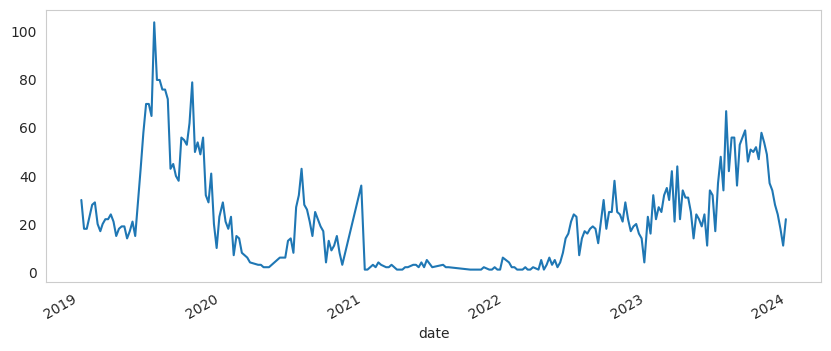

In [9]:
ts['y'].plot(figsize=(10,4))

,ds,y
count,261,261.000000
mean,2021-07-05 00:00:00,27.793361
min,2019-01-07 00:00:00,24.745573
25%,2020-04-06 00:00:00,27.020595
50%,2021-07-05 00:00:00,27.931520
75%,2022-10-03 00:00:00,28.583695
max,2024-01-01 00:00:00,30.859490
std,NaN,1.186961


<Axes: xlabel='date'>

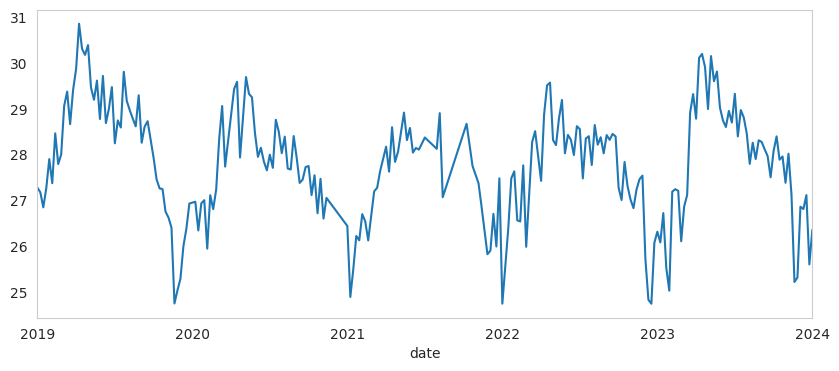

In [49]:
# Create pandas time series with date labels correctly shown. 
# df.date = pd.to_datetime(df.date)
# df.set_index('date',inplace=True)
#df['rolling_weekly_avg'] = df.new_cases.rolling(window=7).mean().fillna(0)

# create timeseries readable by fbprophet
ts_temp = pd.DataFrame({'ds':weekly_summary.index,'y':weekly_summary.temp})

# Need to have bounds if using logistc growth. Unused for linear growth.
#ts['cap'] = 3000000
#ts['floor'] = 0 

ts_temp.describe()
ts_temp['y'].plot(figsize=(10,4))

,ds,y
count,261,261.000000
mean,2021-07-05 00:00:00,1005.687111
min,2019-01-07 00:00:00,1001.129881
25%,2020-04-06 00:00:00,1004.713244
50%,2021-07-05 00:00:00,1005.681907
75%,2022-10-03 00:00:00,1006.762545
max,2024-01-01 00:00:00,1010.282544
std,NaN,1.544346


<Axes: xlabel='date'>

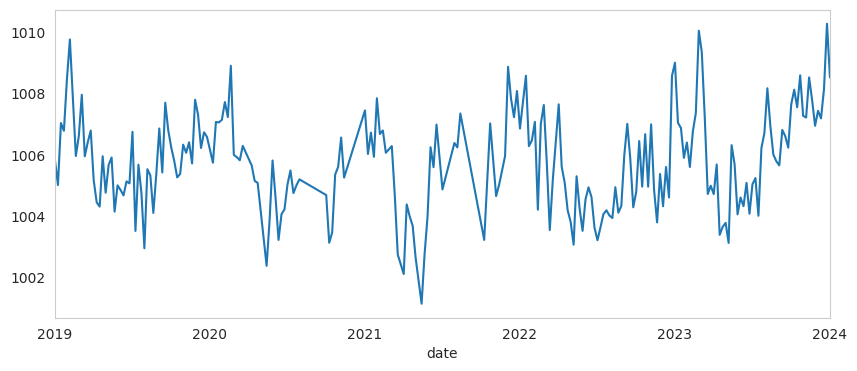

In [50]:
# create timeseries readable by fbprophet
ts_press = pd.DataFrame({'ds':weekly_summary.index,'y':weekly_summary.press})

# Need to have bounds if using logistc growth. Unused for linear growth.
#ts['cap'] = 3000000
#ts['floor'] = 0 

ts_press.describe()
ts_press['y'].plot(figsize=(10,4))

,ds,y
count,261,261.000000
mean,2021-07-05 00:00:00,83.558213
min,2019-01-07 00:00:00,73.612044
25%,2020-04-06 00:00:00,81.379404
50%,2021-07-05 00:00:00,83.294089
75%,2022-10-03 00:00:00,85.379449
max,2024-01-01 00:00:00,96.381224
std,NaN,3.798816


<Axes: xlabel='date'>

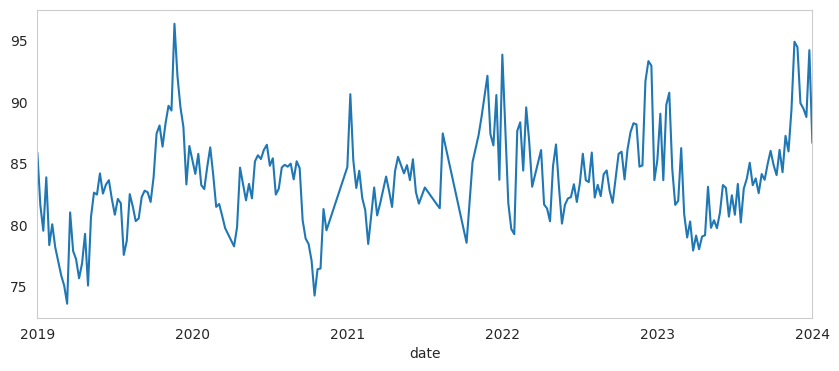

In [52]:
# create timeseries readable by fbprophet
ts_humid = pd.DataFrame({'ds':weekly_summary.index,'y':weekly_summary.humidity})

# Need to have bounds if using logistc growth. Unused for linear growth.
#ts['cap'] = 3000000
#ts['floor'] = 0 

ts_humid.describe()
ts_humid['y'].plot(figsize=(10,4))

,ds,y
count,261,261.000000
mean,2021-07-05 00:00:00,7.904232
min,2019-01-07 00:00:00,0.003690
25%,2020-04-06 00:00:00,2.929524
50%,2021-07-05 00:00:00,5.954167
75%,2022-10-03 00:00:00,9.757465
max,2024-01-01 00:00:00,59.655238
std,NaN,8.307526


<Axes: xlabel='date'>

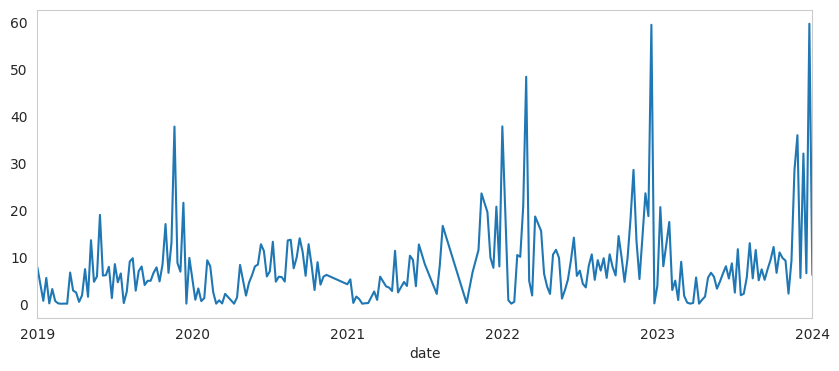

In [53]:
# create timeseries readable by fbprophet
ts_rain = pd.DataFrame({'ds':weekly_summary.index,'y':weekly_summary.rain})

# Need to have bounds if using logistc growth. Unused for linear growth.
#ts['cap'] = 3000000
#ts['floor'] = 0 

ts_rain.describe()
ts_rain['y'].plot(figsize=(10,4))

17:13:48 - cmdstanpy - INFO - Chain [1] start processing
17:13:48 - cmdstanpy - INFO - Chain [1] done processing


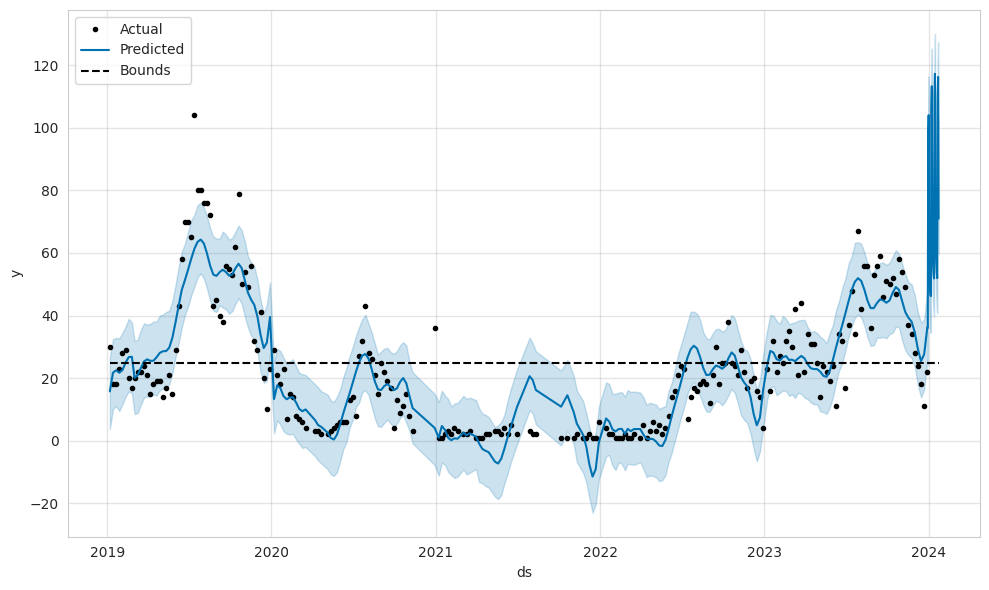

In [11]:
# instantiate the model and fit the timeseries
prophet = Prophet(yearly_seasonality=True, 
                  daily_seasonality=True, 
                  weekly_seasonality=True,
                  growth='linear',
                  n_changepoints= 10,
                  changepoint_range=1, # Consider the whole range for change points
                  changepoint_prior_scale=0.4) # Adjust trend flexibility if it overfits (too large) or underfits (too small).
                                               # Higher value = More flexible trend
prophet.fit(ts)

# Create additional points 25 periods into a future data frame 
future = prophet.make_future_dataframe(periods=25)
future['cap'] = 25
future['floor'] = 0
forecast = prophet.predict(future)

# plot
fig = prophet.plot(forecast)
ax = fig.gca()  # Now you have the matplotlib Axis
ax.legend(['Actual','Predicted','Bounds'])  
pass; 

In [12]:
# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-07,15.778641,3.780346,26.568781
1,2019-01-14,21.739707,10.140978,32.441848
2,2019-01-21,22.505432,11.052383,32.913054
3,2019-01-28,21.726958,9.517518,32.692503
4,2019-02-04,22.591481,11.683449,34.462325


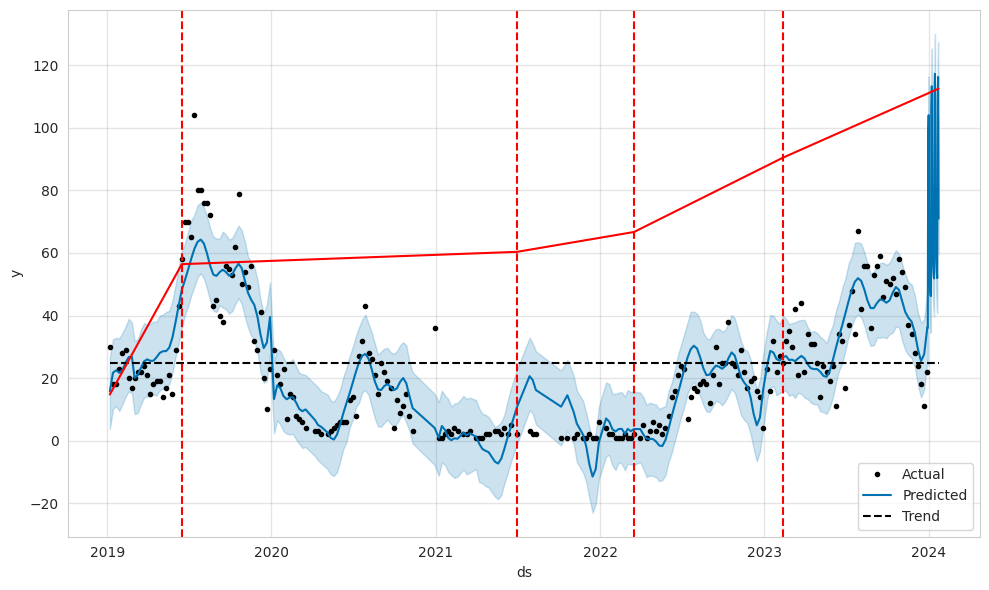

In [13]:
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

ax = fig.gca()  # Now you have the matplotlib Axis
ax.legend(['Actual','Predicted','Trend'])  

In [14]:
df.to_csv(r"data\case_all.csv")

VARMAR

In [5]:
uscon = pd.read_csv('./data/case_all.csv',header=0)
uscon.head()

,date,total_case,temp,press,humidity,rain
0,2019-01-07,30,27.282259,1005.820689,85.897126,7.777041
1,2019-01-14,18,27.177412,1005.009584,81.642037,4.164286
2,2019-01-21,18,26.849482,1007.035567,79.545775,0.621429
3,2019-01-28,23,27.270083,1006.782040,83.890311,5.496281
4,2019-02-04,28,27.903425,1008.452154,78.378565,0.078027


In [6]:
uscon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        232 non-null    object 
 1   total_case  232 non-null    int64  
 2   temp        232 non-null    float64
 3   press       224 non-null    float64
 4   humidity    232 non-null    float64
 5   rain        232 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 11.0+ KB


In [7]:
print('Series has {} missing values'.format(uscon.isna().sum()))

Series has date          0
total_case    0
temp          0
press         8
humidity      0
rain          0
dtype: int64 missing values


In [11]:
print('Series has {} missing values'.format(uscon.isna().sum()))
date_missed = uscon[uscon.isna()].index

Series has date          0
total_case    0
temp          0
press         8
humidity      0
rain          0
dtype: int64 missing values


In [12]:
uscon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        232 non-null    object 
 1   total_case  232 non-null    int64  
 2   temp        232 non-null    float64
 3   press       224 non-null    float64
 4   humidity    232 non-null    float64
 5   rain        232 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 11.0+ KB


TypeError: unhashable type: 'numpy.ndarray'

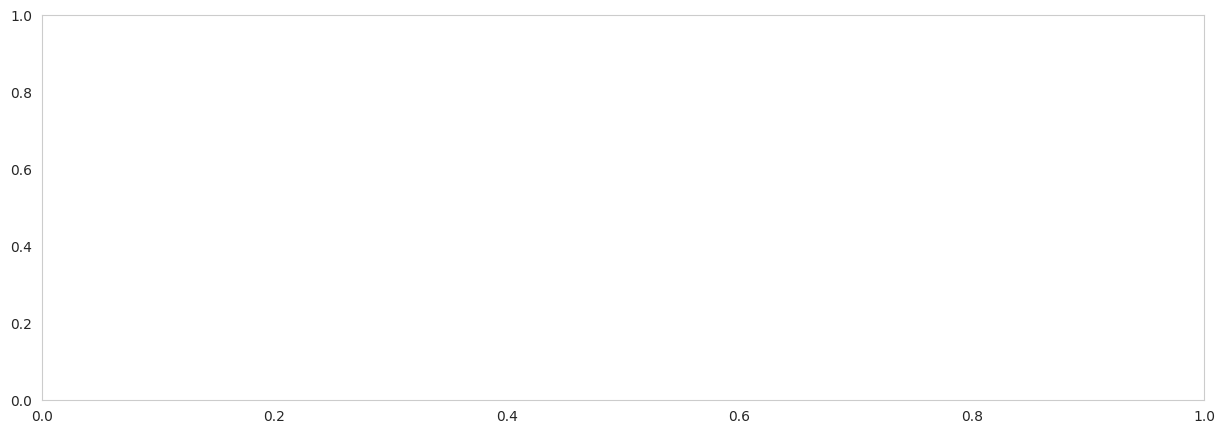

In [9]:
y_filled = uscon.interpolate(method='linear')

plt.figure(figsize=(15,5))
plt.plot(uscon, 'bo--', alpha=0.5, ms=5)
plt.plot(y_filled.loc[date_missed],'ro', ms=5)
plt.show()

In [ ]:
np.log(y_filled).plot(figsize=(10,4))

In [ ]:
# uscon['date'] = pd.to_datetime(uscon['date'])
# uscon = uscon.set_index('date') 
weekly_summary = uscon.resample('W-MON').mean().interpolate(method='linear')
# weekly_summary = uscon.resample('D').sum()
weekly_summary = weekly_summary[weekly_summary['total_case'] != 0]
weekly_summary.head()

In [28]:
weekly_summary.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2019-01-07 to 2024-01-01
Freq: W-MON
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  261 non-null    float64
 1   temp        261 non-null    float64
 2   press       261 non-null    float64
 3   humidity    261 non-null    float64
 4   rain        261 non-null    float64
dtypes: float64(5)
memory usage: 12.2 KB


### Check if the series has a missing value 

In [29]:
print('Series has {} missing values'.format(weekly_summary.isna().sum()))
date_missed = weekly_summary[weekly_summary.isna()].index

Series has total_case    0
temp          0
press         0
humidity      0
rain          0
dtype: int64 missing values


In [14]:
weekly_summary.to_csv(r"./dengue_api/data/weekly_summary.csv")

NameError: name 'weekly_summary' is not defined

In [16]:
weekly_summary = pd.read_csv('./data/weekly_summary.csv')

In [18]:
weekly_summary = weekly_summary.set_index('date')

In [ ]:
y_filled = weekly_summary.interpolate(method='linear')

plt.figure(figsize=(15,5))
plt.plot(weekly_summary, 'bo--', alpha=0.5, ms=5)
plt.plot(y_filled.loc[date_missed],'ro', ms=5)
plt.show()

<Axes: xlabel='date'>

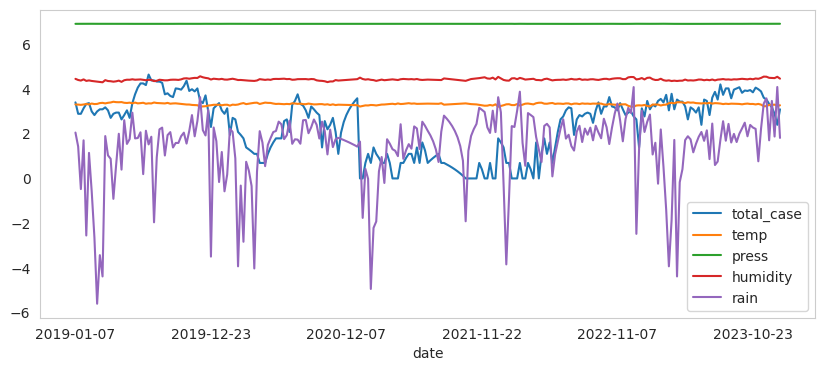

In [20]:
np.log(y_filled).plot(figsize=(10,4))

In [21]:
weekly_summary.head()

,total_case,temp,press,humidity,rain
date,,,,,
2019-01-07,30.0,27.282259,1005.820689,85.897126,7.777041
2019-01-14,18.0,27.177412,1005.009584,81.642037,4.164286
2019-01-21,18.0,26.849482,1007.035567,79.545775,0.621429
2019-01-28,23.0,27.270083,1006.782040,83.890311,5.496281
2019-02-04,28.0,27.903425,1008.452154,78.378565,0.078027


In [22]:
uscon = weekly_summary

In [23]:
uscon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261 entries, 2019-01-07 to 2024-01-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  261 non-null    float64
 1   temp        261 non-null    float64
 2   press       261 non-null    float64
 3   humidity    261 non-null    float64
 4   rain        261 non-null    float64
dtypes: float64(5)
memory usage: 20.3+ KB


### Find best order to fit k_AR_diff

In [24]:
model = VAR(uscon)
print(model.select_order())

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 1, FPE -> 2, HQIC ->  1>


### ADFuller Test

In [25]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is trend stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is stostochastic trend")

In [26]:
for name, column in uscon.items():
    Augmented_Dickey_Fuller_Test_func(uscon[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: total_case
Test Statistic                  -2.426567
p-value                          0.134378
No Lags Used                     7.000000
Number of Observations Used    253.000000
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is stostochastic trend


Results of Dickey-Fuller Test for column: temp
Test Statistic                  -3.742095
p-value                          0.003559
No Lags Used                     6.000000
Number of Observations Used    254.000000
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is trend stationary


Results of Dickey-Fuller Test for column: press
Test Statistic                  -5.526798
p-value                          0.000002
No Lags Used                     1.000000
Number of Observations Used    259.000000
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is trend stationary


Results of Dickey-Fuller Test for column: humidity
Test Statistic              

drop rain เพราะ fail to reject the null hyperthesis

In [18]:
# uscon.drop(['rain'], axis=1, inplace=True)

In [37]:
uscon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2019-01-07 to 2024-01-01
Freq: W-MON
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  261 non-null    float64
 1   temp        261 non-null    float64
 2   press       261 non-null    float64
 3   humidity    261 non-null    float64
 4   rain        261 non-null    float64
dtypes: float64(5)
memory usage: 20.3 KB


### Test for Cointegration

In [27]:
def cointegration_test(df): 
    res = coint_johansen(df,0,3)
    traces = res.lr1        # statistical test values
    cvts = res.cvt[:,1]     # critical value at 95% CI
    print('Column Name > Test Stat > C(95%) => Significant')
    print('----------------------------------------------')
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(col, '>', round(trace,2), ">", round(cvt,2), '=>' , trace > cvt)

In [28]:
cointegration_test(uscon)

Column Name > Test Stat > C(95%) => Significant
----------------------------------------------
total_case > 106.6 > 69.82 => True
temp > 62.95 > 47.85 => True
press > 36.65 > 29.8 => True
humidity > 20.31 > 15.49 => True
rain > 6.72 > 3.84 => True


### Split the data set 

In [29]:
split_ratio = 0.7
train_size = int(len(uscon)*split_ratio)
Y_train, Y_test = uscon[:train_size], uscon[train_size:]

### Grid search VARMA

In [32]:
import itertools

In [33]:
def grid_search_VARMA(Y_train, max_p, max_q):

    results = []

    pq = np.arange(max_p+1), np.arange(max_q+1) 

    for p, q in itertools.product(*pq):
        order = (p, q)
        if order != (0, 0):
            model = VARMAX(Y_train, order=order)
            model_fit = model.fit(disp=False)
            error = model_fit.aicc
            results.append((order, error))
            print(f'VARMAX{order} - AICC:{error}')

    return results

In [34]:
results = grid_search_VARMA(Y_train,3,3)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(0, 1) - AICC:4473.798242140078


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(0, 2) - AICC:4441.539220568534


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(0, 3) - AICC:4579.732165978802


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


VARMAX(1, 0) - AICC:4034.1204663316053


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(1, 1) - AICC:4118.36588863205


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


VARMAX(1, 2) - AICC:4282.725917151952


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


VARMAX(1, 3) - AICC:4545.076502692925


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


VARMAX(2, 0) - AICC:4097.276576464025


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


VARMAX(2, 1) - AICC:4266.677331316743


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


VARMAX(2, 2) - AICC:4570.759348917556


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


VARMAX(2, 3) - AICC:5289.046466384133


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


VARMAX(3, 0) - AICC:4216.158949151262


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


VARMAX(3, 1) - AICC:4529.158562602165


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(3, 2) - AICC:5277.354697609883


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


VARMAX(3, 3) - AICC:9424.785005078527


In [35]:
# Print top 10 best models
print("\nTop 10 best VARMAX configurations:")
for i, (order, error) in enumerate(sorted(results, key=lambda x: x[1])[:10]):
    print(f'{i+1}: VARMAX{order} - AICC:{error}')


Top 10 best VARMAX configurations:
1: VARMAX(1, 0) - AICC:4034.1204663316053
2: VARMAX(2, 0) - AICC:4097.276576464025
3: VARMAX(1, 1) - AICC:4118.36588863205
4: VARMAX(3, 0) - AICC:4216.158949151262
5: VARMAX(2, 1) - AICC:4266.677331316743
6: VARMAX(1, 2) - AICC:4282.725917151952
7: VARMAX(0, 2) - AICC:4441.539220568534
8: VARMAX(0, 1) - AICC:4473.798242140078
9: VARMAX(3, 1) - AICC:4529.158562602165
10: VARMAX(1, 3) - AICC:4545.076502692925


### Fit best model

In [36]:
warnings.filterwarnings("ignore")

best_pq = (1,0) 

In [37]:
best_pq = (2,0)

model = VARMAX(Y_train, order=best_pq, trend='c').fit(disp=False)
model.summary()
print(model.summary())

                                            Statespace Model Results                                           
Dep. Variable:     ['total_case', 'temp', 'press', 'humidity', 'rain']   No. Observations:                  182
Model:                                                          VAR(2)   Log Likelihood               -1933.864
                                                           + intercept   AIC                           4007.727
Date:                                                 Tue, 06 Aug 2024   BIC                           4232.007
Time:                                                         06:31:47   HQIC                          4098.647
Sample:                                                     01-07-2019                                         
                                                          - 06-27-2022                                         
Covariance Type:                                                   opg                                  

In [38]:
model.forecast(4)

,total_case,temp,press,humidity,rain
2022-07-04,20.732534,28.457326,1004.176879,82.078929,6.998711
2022-07-11,21.841972,28.372351,1004.528271,82.410870,7.054796
2022-07-18,22.402786,28.299855,1004.771082,82.602078,6.964315
2022-07-25,22.857836,28.238154,1004.941737,82.757284,7.036920


In [38]:
from statsmodels.tsa.statespace.varmax import VARMAX
from datetime import datetime

In [44]:
from datetime import timedelta

### Fitted values

TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x7fb9fdf0c9d0>.

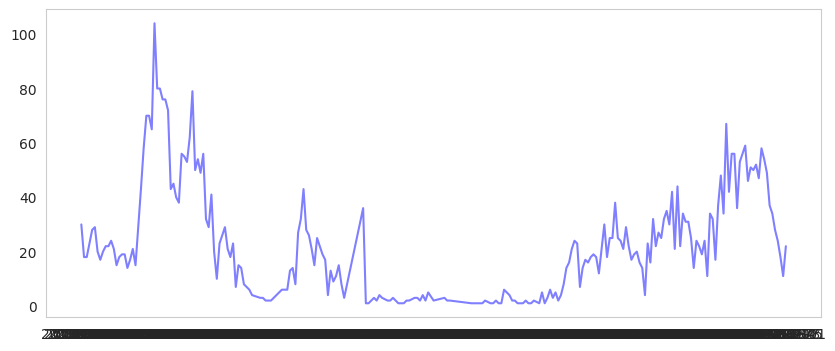

In [39]:
plt.figure(figsize=(10,4))
plt.plot(uscon['total_case'], alpha=0.5, color='blue', label='Original')
plt.plot(model.predict()['total_case'], marker='o', linestyle='--', alpha=0.5, color='green', label='Predicted')
plt.legend()
plt.show()

get_forecast_accuracy(Y_train['total_case'], model.predict()['total_case'])

MAPE ยิ่งน้อยยิ่งดี , WAPE ยิ่งมากยิ่งแม่น

ME: -0.11, RMSE: 7.90, MAPE: 80.76%, WAPE: 28.45%

In [40]:
history = [y for y in Y_train.values]
train = history
predictions = list()
upper_ci = list()
lower_ci = list()


h = 4
for t in range(len(Y_test)-(h-1)):
      
  model_fit = VARMAX(train, order=best_pq).fit(disp=False)
    
  output = model_fit.get_forecast(h)
  predictions.append(output.predicted_mean[h-1])
  lower_ci.append(output.conf_int()[h-1, 0])
  upper_ci.append(output.conf_int()[h-1, 5])

  history.append(Y_test.iloc[t])
  train = history[t+1:]

ME: 2.94, RMSE: 11.90, MAPE: 35.09%, WAPE: 30.03%


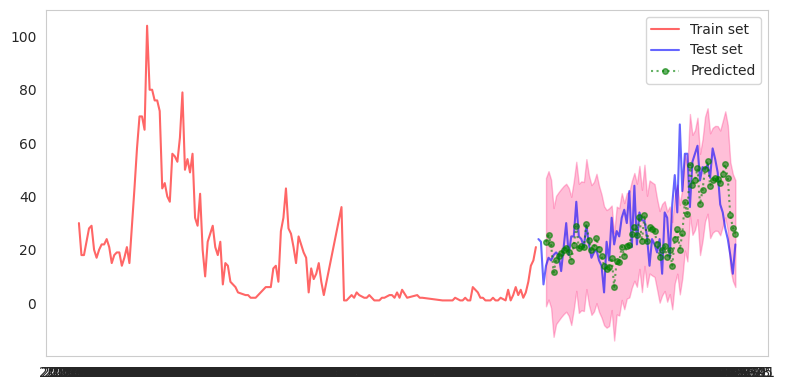

In [41]:
plt.figure(figsize=(8,4))
plt.plot(Y_train['total_case'], label='Train set', color='red', alpha=0.6); 
plt.plot(Y_test['total_case'], label='Test set', color='blue', alpha=0.6); 

predictions_con = pd.Series([i[0] for i in predictions], index=Y_test.index[h-1:])
plt.plot(predictions_con, 'go:', label='Predicted', alpha=0.6, ms=4) 
plt.fill_between(Y_test.index[h-1:], upper_ci, lower_ci, color='#ff0066', alpha=.25)
plt.legend(loc='best')
plt.tight_layout();

get_forecast_accuracy(Y_test['total_case'][h-1:], predictions_con)

ME: 7.71, RMSE: 14.94, MAPE: 36.69%, WAPE: 35.96%

ME: 3.23, RMSE: 12.79, MAPE: 38.25%, WAPE: 31.96%

In [50]:
uscon['total_case'].head()

date
2019-01-07    30.0
2019-01-14    18.0
2019-01-21    18.0
2019-01-28    23.0
2019-02-04    28.0
Name: total_case, dtype: float64

In [51]:
results = model.forecast(h)
results['total_case'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 4 entries, 2022-07-04 to 2022-07-25
Freq: W-MON
Series name: total_case
Non-Null Count  Dtype  
--------------  -----  
4 non-null      float64
dtypes: float64(1)
memory usage: 64.0 bytes


In [52]:
Y_test = Y_test.reset_index()

In [55]:
Y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        79 non-null     datetime64[ns]
 1   total_case  79 non-null     float64       
 2   temp        79 non-null     float64       
 3   press       79 non-null     float64       
 4   humidity    79 non-null     float64       
 5   rain        79 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.8 KB


In [54]:
Y_test['date'] = pd.to_datetime(Y_test['date'])

In [56]:
Y_test = Y_test.set_index('date')

In [57]:
Y_test.index[-1]

Timestamp('2024-01-01 00:00:00')

In [58]:

# Define the total number of days to forecast (4 steps of 7 days each)
n_forecast_days = 4 

# Generate the forecast
forecast = model.get_forecast(steps=n_forecast_days)

# Create a date range starting from the day after the last date of the training data for 28 days
last_date = Y_test.index[-1]

# Generate the start date for each step
forecast_dates = [last_date + timedelta(weeks=1 * i) for i in range(n_forecast_days)]
# forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_forecast_days)

# Convert the forecasted mean to a DataFrame and assign the date range as the index
forecast_mean = forecast.predicted_mean
forecast_mean.index = forecast_dates

# Print the forecast with dates
print(forecast_mean)
forecast_mean.info()

            total_case       temp        press   humidity      rain
2024-01-01   20.732534  28.457326  1004.176879  82.078929  6.998711
2024-01-08   21.841972  28.372351  1004.528271  82.410870  7.054796
2024-01-15   22.402786  28.299855  1004.771082  82.602078  6.964315
2024-01-22   22.857836  28.238154  1004.941737  82.757284  7.036920
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4 entries, 2024-01-01 to 2024-01-22
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  4 non-null      float64
 1   temp        4 non-null      float64
 2   press       4 non-null      float64
 3   humidity    4 non-null      float64
 4   rain        4 non-null      float64
dtypes: float64(5)
memory usage: 192.0 bytes


In [59]:
# Convert 'total_case' column to a Series
total_case_series = forecast_mean['total_case']
total_case_series = forecast_mean.loc[:, 'total_case']
# total_case_series = forecast_mean.loc[:, 'total_case', 'temp']
total_case_series = forecast_mean['total_case']

In [60]:
# Convert Series to DataFrame
total_case_series = total_case_series.reset_index()
total_case_series.columns = ['date', 'total_case']
# Set the 'date' column as the index
total_case_series.set_index('date', inplace=True)
total_case_series

,total_case
date,
2024-01-01,20.732534
2024-01-08,21.841972
2024-01-15,22.402786
2024-01-22,22.857836


In [61]:
Y_test[60:]

,total_case,temp,press,humidity,rain
date,,,,,
2023-08-28,36.0,28.313653,1005.786250,82.600279,4.983929
2023-09-04,53.0,28.278110,1005.653075,84.156917,7.328571
2023-09-11,56.0,28.117338,1006.811199,83.690830,5.094643
2023-09-18,59.0,27.968701,1006.607232,84.969617,7.371429
2023-09-25,46.0,27.506798,1006.231447,86.044161,9.378571
2023-10-02,51.0,28.080661,1007.642788,84.889369,12.098214
2023-10-09,50.0,28.399735,1008.126796,84.069091,6.580476
2023-10-16,52.0,27.890347,1007.552047,86.120294,10.935238
2023-10-23,47.0,27.961412,1008.594460,84.305306,9.746667


In [62]:
upper_ci[57:]

[70.9041301518712,
 63.0891816087733,
 64.8133633525638,
 69.51109440266121,
 55.96746868415758,
 61.454831899802,
 69.8899349086988,
 73.05587014256098,
 63.663718406943616,
 65.69768750379907,
 66.43555194694058,
 66.38171417287994,
 64.70932612187448,
 68.26008579294839,
 71.89554118839322,
 66.72204647275912,
 52.862608881152006,
 48.39037678443758,
 46.12272320782378]

In [63]:
total_case_series

,total_case
date,
2024-01-01,20.732534
2024-01-08,21.841972
2024-01-15,22.402786
2024-01-22,22.857836


In [65]:
uscon['total_case']

date
2019-01-07    30.0
2019-01-14    18.0
2019-01-21    18.0
2019-01-28    23.0
2019-02-04    28.0
              ... 
2023-12-04    28.0
2023-12-11    24.0
2023-12-18    18.0
2023-12-25    11.0
2024-01-01    22.0
Name: total_case, Length: 261, dtype: float64

In [66]:
total_case_series['total_case']

date
2024-01-01    20.732534
2024-01-08    21.841972
2024-01-15    22.402786
2024-01-22    22.857836
Name: total_case, dtype: float64

TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x7fb9d0f74a60>.

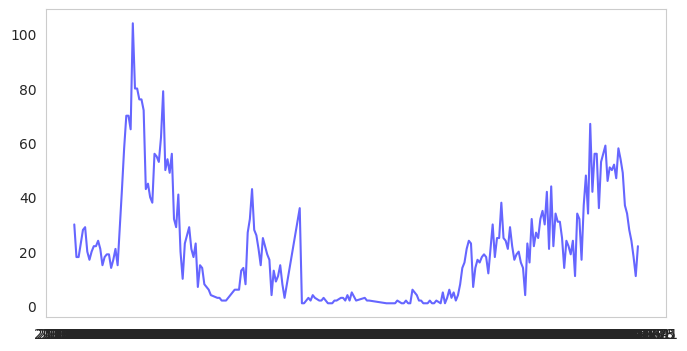

In [67]:
# h = 4

# results = model.forecast(h)

plt.figure(figsize=(8,4))
plt.plot(uscon['total_case'], alpha=0.6, color='blue', label='Original')
plt.plot(total_case_series['total_case'], linestyle='--', alpha=0.6, color='red', label='Predicted')
plt.legend()
plt.show()

In [77]:
DIALECT = "mysql"
SQL_DRIVER = "pymysql"
USERNAME = "user"
PASSWORD = "user"
HOST = "dengue-db"
PORT = 6001
DBNAME = "dengue"

conn_str = DIALECT + "+" + SQL_DRIVER + "://" + USERNAME + ":" +quote(PASSWORD) + "@" + HOST + ":" +str(PORT) + "/" + DBNAME

In [73]:
old_case = uscon['total_case']

In [ ]:
# old_case.info()

In [ ]:
with sa.create_engine(conn_str).connect() as con:
  old_case.to_sql("allcase",con,index=None, if_exists='replace')

In [74]:
forecast_case = total_case_series['total_case'].astype(int)

In [ ]:
# forecast_case.info()

In [ ]:
with sa.create_engine(conn_str).connect() as con:
  forecast_case.to_sql("allcase",con,index=None, if_exists='append')

In [80]:
print('uploaded all case success...')

uploaded all case success...
